In [1]:
import ast
import csv
import gc
import json
import os
import sys
from pprint import pprint
from timeit import default_timer as timer

import numpy as np
import pandas as pd
# import shap
import xgboost as xgb
from IPython.display import display
from hyperopt import STATUS_OK, hp
from hyperopt import tpe, Trials, fmin
from hyperopt.pyll.stochastic import sample
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

main_dir = os.path.abspath(os.pardir)
sys.path.insert(0, main_dir)

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.precision = 8
pd.options.display.float_format = '{:,.3f}'.format

data_path = os.path.join(main_dir, "data")+os.sep
interim_path = os.path.join(data_path, "interim")+os.sep
processed_path = os.path.join(data_path, "processed")+os.sep
models_path = os.path.join(main_dir, "models")+os.sep
predictions_path = os.path.join(main_dir, "models", "predictions")+os.sep
ml_data_fname = "ml_data.gzip"
gbm_trials_fname = 'gbm_trials.csv'
dt_ftm = "%Y/%m/%d, %H:%M:%S"

In [2]:
df1 = pd.read_parquet(interim_path+ml_data_fname, engine="fastparquet")
# leaky_vnames = df1.columns[df1.columns.str.contains("^(jc_|ch_|acc_|phog_|cl_|gabor)")]
# df1 = df1.drop(columns=leaky_vnames)
# df1 = df1[(df1["flip"]=="non_flip") & (df1["rot_id"].isin([0]))]  # , np.random.choice([11,12])
display(df1.head(1))
df1.shape

,filename,class,type,add,img_id,'Auto Color Correlogram0','Auto Color Correlogram1','Auto Color Correlogram2','Auto Color Correlogram3','Auto Color Correlogram48','Auto Color Correlogram49','Auto Color Correlogram50','Auto Color Correlogram51','Auto Color Correlogram52','Auto Color Correlogram53','Auto Color Correlogram54','Auto Color Correlogram55','Auto Color Correlogram56','Auto Color Correlogram57','Auto Color Correlogram58','Auto Color Correlogram59','Auto Color Correlogram60','Auto Color Correlogram61','Auto Color Correlogram62','Auto Color Correlogram63','Spatial Pyramid of Local Binary Patterns0','Spatial Pyramid of Local Binary Patterns1','Spatial Pyramid of Local Binary Patterns2','Spatial Pyramid of Local Binary Patterns3','Spatial Pyramid of Local Binary Patterns4','Spatial Pyramid of Local Binary Patterns5','Spatial Pyramid of Local Binary Patterns6','Spatial Pyramid of Local Binary Patterns7','Spatial Pyramid of Local Binary Patterns8','Spatial Pyramid of Local Binary Patterns9','Spatial Pyramid of Local Binary Patterns10','Spatial Pyramid of Local Binary Patterns11','Spatial Pyramid of Local Binary Patterns12','Spatial Pyramid of Local Binary Patterns13','Spatial Pyramid of Local Binary Patterns14','Spatial Pyramid of Local Binary Patterns15','Spatial Pyramid of Local Binary Patterns16','Spatial Pyramid of Local Binary Patterns17','Spatial Pyramid of Local Binary Patterns18','Spatial Pyramid of Local Binary Patterns19','Spatial Pyramid of Local Binary Patterns20','Spatial Pyramid of Local Binary Patterns21','Spatial Pyramid of Local Binary Patterns22','Spatial Pyramid of Local Binary Patterns23','Spatial Pyramid of Local Binary Patterns24',...,PHOG580,PHOG581,PHOG582,PHOG583,PHOG584,PHOG585,PHOG586,PHOG587,PHOG588,PHOG589,PHOG590,PHOG591,PHOG592,PHOG593,PHOG594,PHOG595,PHOG596,PHOG597,PHOG598,PHOG599,PHOG600,PHOG601,PHOG602,PHOG603,PHOG604,PHOG605,PHOG606,PHOG607,PHOG608,PHOG609,PHOG610,PHOG611,PHOG612,PHOG613,PHOG614,PHOG615,PHOG616,PHOG617,PHOG618,PHOG619,PHOG620,PHOG621,PHOG622,PHOG623,PHOG624,PHOG625,PHOG626,PHOG627,PHOG628,PHOG629
0,trn_t1_1131_0.jpg,t1,trn,non_add,1131,10,8,7,6,15,14,13,13,13,12,11,10,13,12,11,11,14,14,13,13,1,1,2,0,7,0,0,0,15,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,...,10,9,8,11,10,11,11,12,11,14,13,14,15,14,12,12,10,9,10,7,9,9,8,9,7,10,8,9,9,9,9,9,11,12,11,15,12,12,14,11,13,10,9,10,10,10,10,11,9,7


(10239, 1743)

In [3]:
def safe_downcast(series_in, num_type):
    series_out = pd.to_numeric(series_in, downcast=num_type)
    if not np.equal(series_in, series_out).all():
        series_out = series_in
    return series_out

In [4]:
drop_cols = ["type","add","flip","img_id","rot_id", "grp_key", "img_grp"]

In [5]:
object_vnames = df1.select_dtypes("O").columns
int_vnames = df1.select_dtypes("integer").columns
float_vnames = df1.select_dtypes("floating").columns
num_vnames = int_vnames.union(float_vnames).tolist()

if len(int_vnames) > 0:
    df1[int_vnames] = df1[int_vnames].apply(safe_downcast, num_type="unsigned")
if len(float_vnames) > 0:
    df1[float_vnames] = df1[float_vnames].apply(safe_downcast, num_type="float")
if len(object_vnames) > 0:
    df1[object_vnames] = df1[object_vnames].astype("category")
    
gc.collect()
df2 = df1.copy()

object_vnames = [vname for vname in object_vnames if vname not in ["class"]+drop_cols]
float_vnames, num_vnames = [vname for vname in float_vnames if vname not in ["class"]+drop_cols], [vname for vname in num_vnames if vname not in ["class"]+drop_cols]

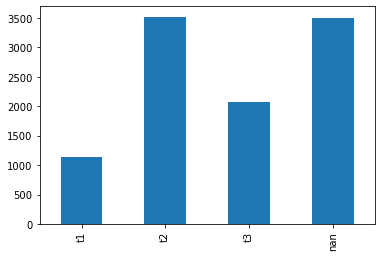

In [6]:
class_cnts = df2["class"].value_counts(dropna=False)
class_cnts.sort_index().plot(kind="bar")

In [7]:
# max_img_grp_trn = len(df2["img_grp"][(df2["class"].notna())].drop_duplicates())

In [8]:
def printDivisors(n): 
    i = 1
    n_w = n
    divs = []
    while (i <= n_w): 
        if (n_w % i==0) & (i >= 6) & (i <= 10):
            drop_n = n-n_w
            print("Int divisor for", n_w, "is", str(i)+". Drop", drop_n,"image groups.")
            return drop_n, i
        if (n_w == i):
            n_w -= 1
            i = 0
        i = i + 1

In [9]:
# drop_n, cv_folds = printDivisors(max_img_grp_trn)
# img_grp_drop = df2["img_grp"][(df2["class"]==class_cnts.index[0]) & (df2["type"]=="trn")].drop_duplicates().sample(n=drop_n, random_state=123)
train_data = df2[df2["class"].notna()]
# drop_ind = train_data["img_grp"][train_data["img_grp"].isin(img_grp_drop)].index
# train_data = train_data.drop(index=drop_ind)
cv_folds = 5

In [10]:
train_data = train_data.drop(columns=drop_cols, errors="ignore")
vld_fnames = train_data["filename"][train_data["filename"].str.startswith("vld_")]
test_data = df2[df2["filename"].isin(vld_fnames)].reset_index(drop=True).append(
    df2[df2["class"].isna()], ignore_index=True).drop(columns=drop_cols, errors="ignore")
test_data["filename"] = test_data["filename"].str.replace("^(tst_|vld_t\d_)", "")
test_data["filename"] = test_data["filename"][test_data["filename"].str.contains("(?<!flip)_0.jpg")].str.replace("_0.jpg", ".jpg")
test_data = test_data[test_data["filename"].notna()].reset_index(drop=True)

display(train_data.head(2), test_data.head(2))

,filename,class,'Auto Color Correlogram0','Auto Color Correlogram1','Auto Color Correlogram2','Auto Color Correlogram3','Auto Color Correlogram48','Auto Color Correlogram49','Auto Color Correlogram50','Auto Color Correlogram51','Auto Color Correlogram52','Auto Color Correlogram53','Auto Color Correlogram54','Auto Color Correlogram55','Auto Color Correlogram56','Auto Color Correlogram57','Auto Color Correlogram58','Auto Color Correlogram59','Auto Color Correlogram60','Auto Color Correlogram61','Auto Color Correlogram62','Auto Color Correlogram63','Spatial Pyramid of Local Binary Patterns0','Spatial Pyramid of Local Binary Patterns1','Spatial Pyramid of Local Binary Patterns2','Spatial Pyramid of Local Binary Patterns3','Spatial Pyramid of Local Binary Patterns4','Spatial Pyramid of Local Binary Patterns5','Spatial Pyramid of Local Binary Patterns6','Spatial Pyramid of Local Binary Patterns7','Spatial Pyramid of Local Binary Patterns8','Spatial Pyramid of Local Binary Patterns9','Spatial Pyramid of Local Binary Patterns10','Spatial Pyramid of Local Binary Patterns11','Spatial Pyramid of Local Binary Patterns12','Spatial Pyramid of Local Binary Patterns13','Spatial Pyramid of Local Binary Patterns14','Spatial Pyramid of Local Binary Patterns15','Spatial Pyramid of Local Binary Patterns16','Spatial Pyramid of Local Binary Patterns17','Spatial Pyramid of Local Binary Patterns18','Spatial Pyramid of Local Binary Patterns19','Spatial Pyramid of Local Binary Patterns20','Spatial Pyramid of Local Binary Patterns21','Spatial Pyramid of Local Binary Patterns22','Spatial Pyramid of Local Binary Patterns23','Spatial Pyramid of Local Binary Patterns24','Spatial Pyramid of Local Binary Patterns25','Spatial Pyramid of Local Binary Patterns26','Spatial Pyramid of Local Binary Patterns27',...,PHOG580,PHOG581,PHOG582,PHOG583,PHOG584,PHOG585,PHOG586,PHOG587,PHOG588,PHOG589,PHOG590,PHOG591,PHOG592,PHOG593,PHOG594,PHOG595,PHOG596,PHOG597,PHOG598,PHOG599,PHOG600,PHOG601,PHOG602,PHOG603,PHOG604,PHOG605,PHOG606,PHOG607,PHOG608,PHOG609,PHOG610,PHOG611,PHOG612,PHOG613,PHOG614,PHOG615,PHOG616,PHOG617,PHOG618,PHOG619,PHOG620,PHOG621,PHOG622,PHOG623,PHOG624,PHOG625,PHOG626,PHOG627,PHOG628,PHOG629
0,trn_t1_1131_0.jpg,t1,10,8,7,6,15,14,13,13,13,12,11,10,13,12,11,11,14,14,13,13,1,1,2,0,7,0,0,0,15,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,2,...,10,9,8,11,10,11,11,12,11,14,13,14,15,14,12,12,10,9,10,7,9,9,8,9,7,10,8,9,9,9,9,9,11,12,11,15,12,12,14,11,13,10,9,10,10,10,10,11,9,7
1,trn_t1_1220_0.jpg,t1,12,11,10,9,15,15,15,14,15,14,14,13,15,14,13,12,15,15,14,14,0,0,0,0,2,0,0,0,15,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,...,6,7,10,12,11,15,10,8,6,7,9,6,4,4,4,2,1,1,1,0,0,1,0,1,3,4,3,5,4,4,5,1,2,4,3,4,4,6,6,5,3,5,5,14,11,6,3,2,1,2


,filename,class,'Auto Color Correlogram0','Auto Color Correlogram1','Auto Color Correlogram2','Auto Color Correlogram3','Auto Color Correlogram48','Auto Color Correlogram49','Auto Color Correlogram50','Auto Color Correlogram51','Auto Color Correlogram52','Auto Color Correlogram53','Auto Color Correlogram54','Auto Color Correlogram55','Auto Color Correlogram56','Auto Color Correlogram57','Auto Color Correlogram58','Auto Color Correlogram59','Auto Color Correlogram60','Auto Color Correlogram61','Auto Color Correlogram62','Auto Color Correlogram63','Spatial Pyramid of Local Binary Patterns0','Spatial Pyramid of Local Binary Patterns1','Spatial Pyramid of Local Binary Patterns2','Spatial Pyramid of Local Binary Patterns3','Spatial Pyramid of Local Binary Patterns4','Spatial Pyramid of Local Binary Patterns5','Spatial Pyramid of Local Binary Patterns6','Spatial Pyramid of Local Binary Patterns7','Spatial Pyramid of Local Binary Patterns8','Spatial Pyramid of Local Binary Patterns9','Spatial Pyramid of Local Binary Patterns10','Spatial Pyramid of Local Binary Patterns11','Spatial Pyramid of Local Binary Patterns12','Spatial Pyramid of Local Binary Patterns13','Spatial Pyramid of Local Binary Patterns14','Spatial Pyramid of Local Binary Patterns15','Spatial Pyramid of Local Binary Patterns16','Spatial Pyramid of Local Binary Patterns17','Spatial Pyramid of Local Binary Patterns18','Spatial Pyramid of Local Binary Patterns19','Spatial Pyramid of Local Binary Patterns20','Spatial Pyramid of Local Binary Patterns21','Spatial Pyramid of Local Binary Patterns22','Spatial Pyramid of Local Binary Patterns23','Spatial Pyramid of Local Binary Patterns24','Spatial Pyramid of Local Binary Patterns25','Spatial Pyramid of Local Binary Patterns26','Spatial Pyramid of Local Binary Patterns27',...,PHOG580,PHOG581,PHOG582,PHOG583,PHOG584,PHOG585,PHOG586,PHOG587,PHOG588,PHOG589,PHOG590,PHOG591,PHOG592,PHOG593,PHOG594,PHOG595,PHOG596,PHOG597,PHOG598,PHOG599,PHOG600,PHOG601,PHOG602,PHOG603,PHOG604,PHOG605,PHOG606,PHOG607,PHOG608,PHOG609,PHOG610,PHOG611,PHOG612,PHOG613,PHOG614,PHOG615,PHOG616,PHOG617,PHOG618,PHOG619,PHOG620,PHOG621,PHOG622,PHOG623,PHOG624,PHOG625,PHOG626,PHOG627,PHOG628,PHOG629
0,100.jpg,t1,13,11,10,9,15,15,14,14,14,14,13,12,15,14,13,13,15,15,15,14,0,0,0,0,4,0,0,0,15,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,1,...,5,6,9,10,11,15,10,8,9,9,8,6,3,1,1,0,0,0,0,0,5,3,4,3,5,6,10,14,10,4,3,4,6,6,10,12,11,7,10,11,8,7,7,7,12,13,10,11,8,7
1,103.jpg,t1,12,11,11,10,15,14,14,13,14,13,13,12,14,14,13,12,15,15,14,14,0,0,0,0,3,0,0,0,15,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,...,12,15,11,9,7,6,1,1,1,2,2,4,4,5,4,4,6,2,2,3,3,2,1,1,2,1,2,2,2,1,2,11,13,12,11,11,4,3,4,5,8,11,14,15,13,11,9,5,3,3


In [11]:
# train_data[num_vnames].to_csv(processed_path+"train_data.csv")

In [12]:
X_train, y_train = train_data[num_vnames], train_data["class"]
X_test = test_data[num_vnames]

class_le = LabelEncoder().fit(y_train)
y_train = pd.Series(class_le.transform(y_train), index=y_train.index, dtype=np.uint8)

In [13]:
display(X_train.head(1), y_train.head())

,'Auto Color Correlogram0','Auto Color Correlogram1','Auto Color Correlogram2','Auto Color Correlogram3','Auto Color Correlogram48','Auto Color Correlogram49','Auto Color Correlogram50','Auto Color Correlogram51','Auto Color Correlogram52','Auto Color Correlogram53','Auto Color Correlogram54','Auto Color Correlogram55','Auto Color Correlogram56','Auto Color Correlogram57','Auto Color Correlogram58','Auto Color Correlogram59','Auto Color Correlogram60','Auto Color Correlogram61','Auto Color Correlogram62','Auto Color Correlogram63','Fuzzy Opponent Histogram17','Fuzzy Opponent Histogram18','Fuzzy Opponent Histogram4','Fuzzy Opponent Histogram5','Fuzzy Opponent Histogram7','Fuzzy Opponent Histogram8','Fuzzy Opponent Histogram9','Gabor Features0','Gabor Features1','Gabor Features10','Gabor Features11','Gabor Features12','Gabor Features13','Gabor Features14','Gabor Features15','Gabor Features16','Gabor Features17','Gabor Features18','Gabor Features19','Gabor Features2','Gabor Features20','Gabor Features21','Gabor Features22','Gabor Features23','Gabor Features24','Gabor Features25','Gabor Features26','Gabor Features27','Gabor Features28','Gabor Features29',...,PHOG620,PHOG621,PHOG622,PHOG623,PHOG624,PHOG625,PHOG626,PHOG627,PHOG628,PHOG629,PHOG63,PHOG64,PHOG65,PHOG66,PHOG67,PHOG68,PHOG69,PHOG7,PHOG70,PHOG71,PHOG72,PHOG73,PHOG74,PHOG75,PHOG76,PHOG77,PHOG78,PHOG79,PHOG8,PHOG80,PHOG81,PHOG82,PHOG83,PHOG84,PHOG85,PHOG86,PHOG87,PHOG88,PHOG89,PHOG9,PHOG90,PHOG91,PHOG92,PHOG93,PHOG94,PHOG95,PHOG96,PHOG97,PHOG98,PHOG99
0,10,8,7,6,15,14,13,13,13,12,11,10,13,12,11,11,14,14,13,13,6,50,5,7,3,24,7,9.828,0.111,9.831,0.111,10.157,0.114,10.160,0.114,10.160,0.114,10.157,0.114,9.831,10.160,0.114,10.160,0.114,10.147,0.114,10.151,0.114,10.151,0.114,...,13,10,9,10,10,10,10,11,9,7,4,6,7,7,7,8,9,9,8,8,9,10,11,15,12,12,12,9,10,10,9,7,6,4,4,3,3,3,3,10,11,10,9,9,9,11,13,13,14,13


0    0
1    0
2    0
3    0
4    0
dtype: uint8

In [14]:
print(len(X_train))

6733


In [15]:
sample_weights = pd.Series(compute_sample_weight('balanced', y_train), index=X_train.index)
xgtrain = xgb.DMatrix(X_train.values, label=y_train.values, weight=sample_weights, nthread=-1)
xgtest = xgb.DMatrix(X_test.values, nthread=-1)

In [ ]:
{'booster': 'dart', 'colsample_bytree': 0.2295419830675599, 'eta': 0.31120689010895325, 'eval_metric': 'mlogloss', 'grow_policy': 'lossguide', 'max_depth': 64, 'max_leaves': 3101, 'num_class': 3, 'objective': 'multi:softprob', 'subsample': 0.9510197641237615, 'tree_method': 'hist'}

In [21]:
params = {
    # Parameters that we are going to tune.
    'booster': "gbtree",
    'max_depth': 64,  # 182,
    'max_leaves': 3101,  # 95525,
    'eta': 0.31120689010895325,  # 0.028031763656143734,
    'subsample': 0.9510197641237615, # 0.9686928240077186,
    'colsample_bytree': 0.2295419830675599,  # 0.5159570456915784,
    
    # Other parameters
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': y_train.nunique()}

max_trees = 11  # 116
EARLY_STOP = 5
target = "class"

In [17]:
def objective(param):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ["max_depth", "max_leaves"]:
        param[parameter_name] = int(param[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    if ITERATION % (EARLY_STOP*10) == 0:
        gc.collect()
    cv_results = xgb.cv(param, xgtrain, num_boost_round=max_trees, nfold=cv_folds, stratified=True, metrics=param["eval_metric"],
                    early_stopping_rounds=EARLY_STOP, shuffle=True, verbose_eval=False)
    
    run_time = timer() - start
    
    # Extract the best score
    mean_error = cv_results["train-"+param["eval_metric"]+"-mean"]
    mean_error = mean_error[mean_error == mean_error.min()]
    best_score = mean_error.iloc[0]
    
    # Boosting rounds that returned the highest cv score
    n_estimators = mean_error.index.values[0]+1

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a', newline="")
    writer = csv.writer(of_connection, delimiter=',')
    writer.writerow([best_score, param, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': best_score, 'param': param, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [18]:
# test_dct = {'max_leaves': hp.uniform('max_leaves', 15, np.iinfo(np.uint32).max-1),}
# temp_lst = []
# for i in range(10000):
#     temp_lst += [sample(test_dct)['max_leaves']]
# temp_lst = pd.Series(temp_lst).sort_values().reset_index(drop=True)
# temp_lst.value_counts().sort_index().plot(kind="area")

In [19]:
# Global variable
ITERATION = 0
MAX_EVALS = 200

# Define the search space
space = {
    'booster': hp.choice('booster', ['dart', 'gbtree']),
    
    # ints
    'max_depth': hp.uniform('max_depth', 1, 100),
    'max_leaves': hp.uniform('max_leaves', 1, 4095),
    
    # floats
    'eta': hp.uniform('eta', 0.1, 1),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    
    # Other parameters
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': y_train.nunique()}

# Sample from the full space
example = sample(space)

print(example)

# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

# File to save first results
out_file = models_path+gbm_trials_fname
of_connection = open(out_file, 'w', newline="")
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

{'booster': 'gbtree', 'colsample_bytree': 0.6372227762364179, 'eta': 0.3275891422194694, 'eval_metric': 'mlogloss', 'grow_policy': 'lossguide', 'max_depth': 62.21069860655338, 'max_leaves': 1240.6113599620744, 'num_class': 3, 'objective': 'multi:softprob', 'subsample': 0.8924384454180798, 'tree_method': 'hist'}


In [20]:
# Run optimization
start_time = pd.to_datetime("now")
print("Start time", start_time.strftime(dt_ftm))

best = fmin(fn=objective, space=space, algo =tpe_algorithm, 
            max_evals=MAX_EVALS, trials=bayes_trials, rstate=np.random.RandomState(123))

finish_time = pd.to_datetime("now")
print("Finish time", finish_time.strftime(dt_ftm), "or", round((finish_time-start_time).seconds/60), "minutes.\n")

Start time 2020/05/24, 11:46:21
 74%|███████████████████████████████████████████████████████▌                   | 148/200 [1:58:11<41:31, 47.91s/trial, best loss: 0.09767020000000001]


KeyboardInterrupt: 

In [ ]:
# Sort the trials with lowest loss (lower mlogloss) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
for cfg in bayes_trials_results[:3]:
    pprint(cfg)

In [ ]:
# Open the results again
results = pd.read_csv(models_path+gbm_trials_fname)
print('These parameters were discovered through {} search iterations'.format(results['iteration'].max()))

# Sort values with best on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

In [ ]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [22]:
# Re-create the best model and train on the training data
xgb_model_evals_res = dict()
xgb_model = xgb.train(params=params, dtrain=xgtrain, num_boost_round=max_trees, evals=[(xgtrain, "train")],  # best_bayes_params, best_bayes_estimators
                             evals_result=xgb_model_evals_res, verbose_eval=10)

xgb_model.save_model(models_path+'current_best.xgb')
# xgb_model.dump_model(models_path+'current_best_xgb'+'_raw.txt', models_path+'current_best_xgb'+'_featmap.txt')
with open(models_path+'current_best_xgb'+'_cfg.json', 'w') as outfile:
    json.dump(xgb_model.save_config(), outfile)

[0]	train-mlogloss:0.79970
[10]	train-mlogloss:0.09725


In [23]:
#Predict test set:
predictions = dict()
for n_trees in [11]: # range(max_trees, int(max_trees//8)-1, -int(max_trees//8)):
    predictions[n_trees] = pd.DataFrame(xgb_model.predict(xgtest, ntree_limit=n_trees))
    predictions[n_trees].columns = pd.Series(class_le.inverse_transform(predictions[n_trees].columns.tolist())).str.replace("t", "Type_")
    predictions[n_trees] = pd.concat([test_data["filename"].rename("image_name"), predictions[n_trees]], axis=1)
    predictions[n_trees].to_csv(predictions_path+"xgb_pred_"+str(n_trees)+".csv", index=False)

In [24]:
predictions[n_trees].head()

,image_name,Type_1,Type_2,Type_3
0,100.jpg,0.894,0.063,0.043
1,103.jpg,0.902,0.044,0.054
2,111.jpg,0.923,0.043,0.034
3,123.jpg,0.916,0.048,0.036
4,142.jpg,0.937,0.032,0.031


In [65]:
# # load JS visualization code to notebook
# shap.initjs()

# shap_ind = X_test.sample(n=1000, random_state=123).index
# shap_xgb_X = X_test.loc[shap_ind]
# # shap_xgb_y = y_train.loc[shap_ind]

In [66]:
# explainer = shap.TreeExplainer(xgb_model)
# shap_values = explainer.shap_values(shap_xgb_X)

In [67]:
# # summarize the effects of all the features
# shap.summary_plot(shap_values, shap_xgb_X)